# Predicting 'Overall' rating in the FIFA video game using real life data

The goal of this project is to find a model that accurately predicts players' 'Overall' ratings in the FIFA video game using real life data from the previous season. For example, the 'FIFA 19' video game was released on September 30, 2018 for the 2018-2019 season. Therefore, real life data from the 2017-2018 season will be used for predicting the players 'FIFA 19' rating. The data was scraped from multiple sources, [FBREF](https://fbref.com/en/) for the real life data and [FIFA Index](https://www.fifaindex.com/) for the FIFA player ratings. Data from the 'Big 5' Leagues in Europe (England, France, Germany, Italy and Spain) was used starting with the 2017-2018 season up through the 2020-2021 season. Data from Club tournaments (Champions League and Europa League, which occur every year) as well as Country tournamnets (World Cup, Euro Cup and Copa America), were added as well. Lets take a look at the data.

In [1]:
#Loading in required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
#this cell centers tables/graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Exploratory Data Analysis

In [3]:
#Loading the data
data = pd.read_csv('fut_data.csv')
print(data.shape)

(7527, 85)


There are 7,527 rows (Players) in the dataset, with 85 variables. Look at the [Variable Descriptions pdf](https://github.com/mtwatso2/Fifa-Ratings-Updated/blob/main/Variable%20Descriptions.pdf) in the [GitHub repository](https://github.com/mtwatso2/Fifa-Ratings-Updated) to see an explination for each of these variables. Let's start off by taking a look at the 'MP' (Matches played) and 'Min' (Total Minutes played) columns. 

In [4]:
print('Matches Played Summary Statistics:')
print(data['MP'].describe(), '\n')
print('Total Minutes Played Summary Statistics:')
print(data['Min'].describe())

Matches Played Summary Statistics:
count    7527.000000
mean       22.255480
std        11.898453
min         1.000000
25%        13.000000
50%        24.000000
75%        32.000000
max        56.000000
Name: MP, dtype: float64 

Total Minutes Played Summary Statistics:
count    7527.000000
mean     1525.712900
std      1021.358971
min         1.000000
25%       640.000000
50%      1486.000000
75%      2327.500000
max      4547.000000
Name: Min, dtype: float64


As we can see above, the mean number of games played is roughly 22, with a mean number of minutes played at around 1,500. However, we can also see that the minimum value for both of these variables is '1'. Using data from 1 minute of play time, or even 1 game, is not enough for predicting a players FIFA 'Overall' rating. It is likely that there are players who have mulitple games played, but a very low number of minutes due to being subbed on, so it makes more sense to subset the data based on minutes played instead of matches played. The length of a regular game is 90 minutes (not including stoppage time). The 25th percentile is 640 minutes, or roughly 7 games played. Let's subset the data to only inlcude players who have played a minimum of 3 full games (270 minutes). 

In [5]:
sub = data[data['Min'] >= 270]
print(sub.shape)

(6427, 85)


We are left with 6,427 out of the original 7,527 observations after removing players with less than 3 games, meaning 1,100, or roughly 14.6% of the observations were removed. Let's take a look at the summary statistics again

In [6]:
print('Matches Played Summary Statistics:')
print(sub['MP'].describe(), '\n')
print('Total Minutes Played Summary Statistics:')
print(sub['Min'].describe())

Matches Played Summary Statistics:
count    6427.000000
mean       25.463047
std         9.701794
min         3.000000
25%        18.000000
50%        26.000000
75%        33.000000
max        56.000000
Name: MP, dtype: float64 

Total Minutes Played Summary Statistics:
count    6427.000000
mean     1770.004512
std       901.236286
min       270.000000
25%      1014.500000
50%      1725.000000
75%      2466.500000
max      4547.000000
Name: Min, dtype: float64


The mean for 'MP' increased from 22.25 to 25.46 while the mean for 'Min' increased from roughly 1525 to 1770. Both of these are good for analysis, as there is data from more games available on average for each player. Let's take a look at the target variable, 'Overall'. 

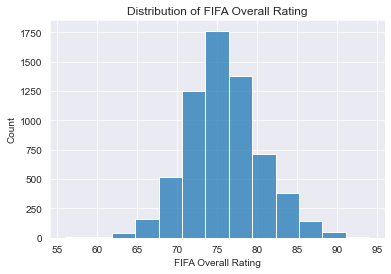

In [7]:
sns.set_style('darkgrid') #setting style for all graphs
sns.histplot(x = sub.Overall, bins=13)
plt.xlabel('FIFA Overall Rating')
plt.title('Distribution of FIFA Overall Rating')
plt.show()

Looks to be roughly normally distributed with median and mean 'Overall' around 75. 

Overall Rating Summary Statistics:
count    6427.000000
mean       75.855765
std         4.784059
min        56.000000
25%        73.000000
50%        76.000000
75%        79.000000
max        94.000000
Name: Overall, dtype: float64


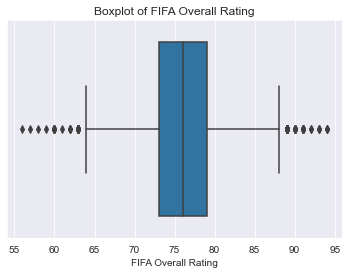

In [8]:
print('Overall Rating Summary Statistics:')
print(sub.Overall.describe())

sns.boxplot(x = sub.Overall)
plt.xlabel('FIFA Overall Rating')
plt.title('Boxplot of FIFA Overall Rating')
plt.show()

'Overall' ranges from 56 to 94 with a mean of roughly 76. The IQR ranges from 73 to 79, meaning 50% of the players in the data fall into this range. We can see this in the boxplot as well. It looks like some of the extremes on both ends are showing up as outliers. Players with ratings over 88 are outliers (top players) as well as players with ratings under 64. I would guess that the players with lower ratings will tend to be younger players. It is worth noting that there are players in the FIFA video game with ratings higher than 94, but those are special 'cards' based on a single game/season performace. The only 'cards' used in this analysis are the base 'cards' available when the game is released. 

count    38.000000
mean     20.947368
std       4.158660
min      17.000000
25%      19.000000
50%      19.500000
75%      21.000000
max      35.000000
Name: Age, dtype: float64


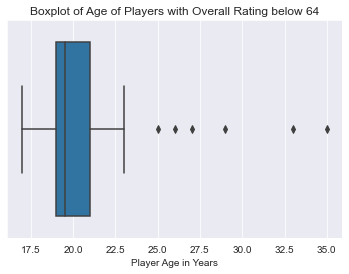

In [9]:
low = sub[sub.Overall < 64]
print(low.Age.describe())
sns.boxplot(x = low.Age)
plt.xlabel('Player Age in Years')
plt.title('Boxplot of Age of Players with Overall Rating below 64')
plt.show()

As expected, 75% of the 38 players with low ratings are 21 or younger, with players older than 23 being outliers. Next, lets take a look at 'Comp' (League) and 'Game' (which FIFA).

In [10]:
pd.crosstab(sub['Comp'], sub['Game'])

Game,19,20,21,22
Comp,,,,
Bundesliga,317,322,319,315
La Liga,279,277,284,259
Ligue 1,317,308,298,305
Premier League,340,363,373,350
Serie A,357,344,359,341


Above we can see the total number of players present from each of the leagues in each of the FIFA games. There is not too much variation from year to year for each league. Interestingly, there are less players from La Liga (Spanish league) across all years. This is likely due to an issue with merging data from mulitple sources; the players' names were stored differently in the data sources used. Spanish names have accents more frequently than other languages, so this could be responsible. 

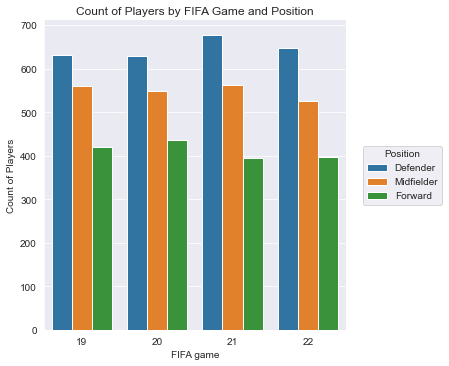

In [11]:
sns.catplot(x='Game', data=sub, hue='Pos', kind='count', legend = False)
plt.xlabel('FIFA game')
plt.ylabel('Count of Players')
plt.title('Count of Players by FIFA Game and Position')
plt.legend(title = 'Position', labels=['Defender', 'Midfielder', 'Forward'], bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

Above we can see the total number of players by position for each FIFA game. It looks like for each year, there are more Defenders ('DF'), followed by Midfielders ('MF') and lastly Forwards ('FW'). There does not appear to be very much variation across games/years as well. It is worth noting, however, that players can play multiple positions during the season. The data was cleaned earlier, for example the data from FBREF would list a players position, 'Pos', as 'LBLM', meaning the player has played both Left Back 'LB' (a defenseive position) and Left Midfielder 'LM' during the season. For simplictiy, I just used the first position listed when editing the variable, so a 'LBLM' player would be changed to simply 'DF'. Next, lets take a look at the relationship between 'Overall' and some of the numeric data.

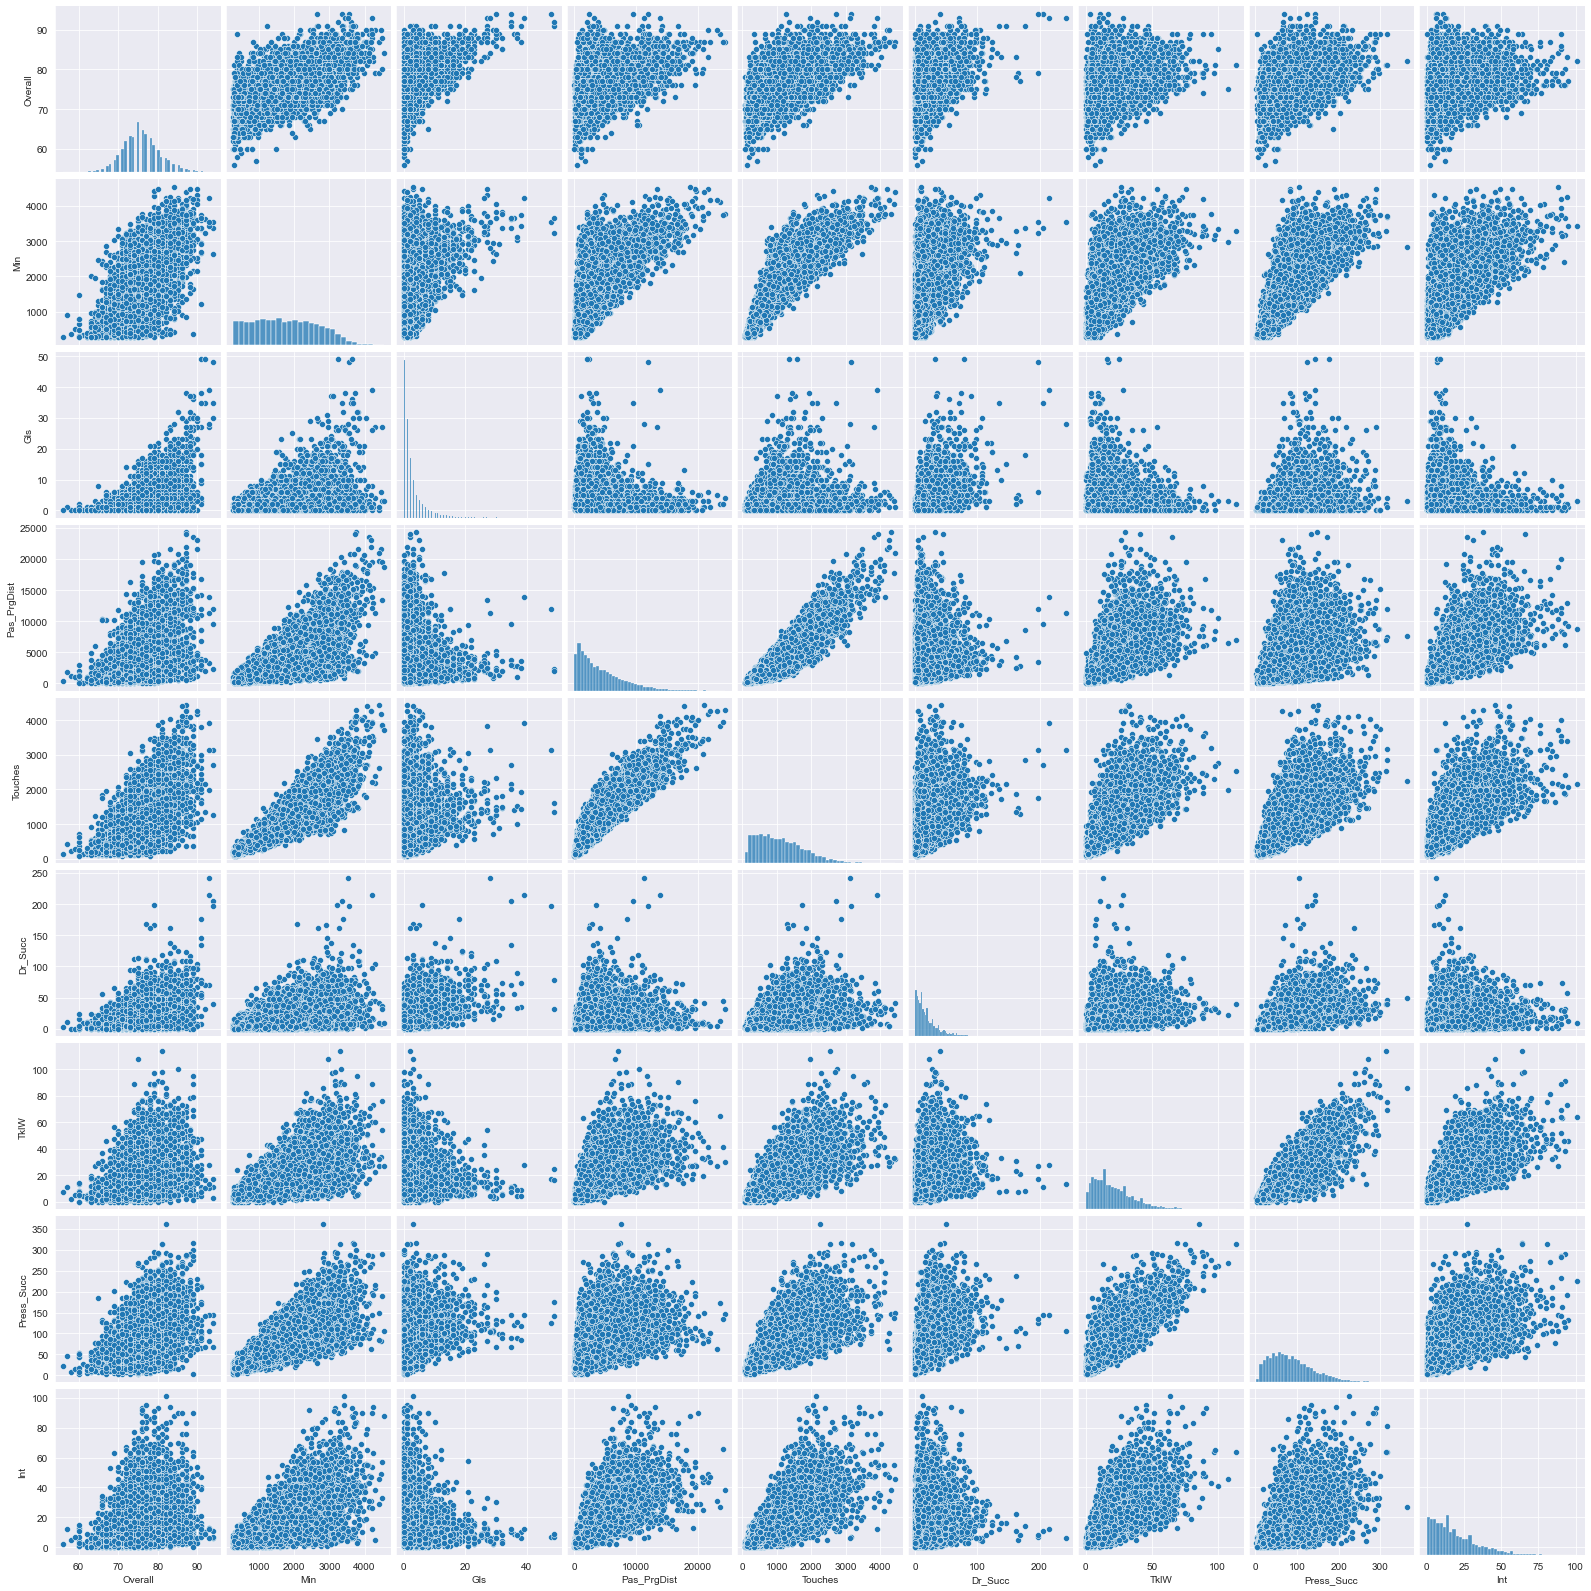

In [12]:
num = sub[['Overall', 'Min', 'Gls', 'Pas_PrgDist', 'Touches', 'Dr_Succ', 'TklW', 'Press_Succ', 'Int']]
sns.pairplot(num)
plt.show()

Besides 'Overall,' the other variables selected seem to be right skewed. There does not appear to be any very strong possitive correlations between 'Overall' and the other variables, which we can check with heat map below. 'Touches' seems to have a strong, positive correlation with 'Min' and 'Pas_PrgDist' which makes sense, as you'll have more touches the more you play, which in turn results in more passes. 

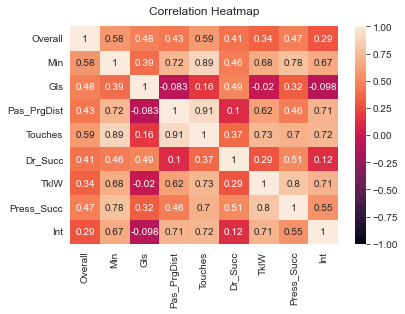

In [13]:
sns.heatmap(num.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

As predicted above, the strongest correlation in the matrix is between 'Touches', 'Min' and 'Pas_PrgDist'. 'Overall' has a correlation between 0.29 and 0.59 with all of these variables, which is moderately high. Next, let's start creating some models to predict 'Overall'.

## Predicting Overall Rating

First, some more data preprocessing needs to be done before models can be ran. Certain columns need to be changed from 'obj' to 'category' so dummy variables can be created. Certain columns can also be dropped, such as 'Name' and 'Nation' as they cannot be used in predictive models. 'Born' is also dropped, as it essentially contains the same information as 'Age'. The data also needs to be scaled, as certain columns are on very different scales. For example, as seen above, 'Min' ranges from 270 to 4,547, while many other variables dont even go above 100. 

In [14]:
sub = sub.astype({'Game':'category', 'Comp':'category', 'Pos':'category'}) #change dtype so dummies can be created 

target = sub[['Overall']] #target variable

d = sub.drop(['Player', 'Nation', 'Squad', 'Born', 'Overall'], axis=1) #remove unneeded columns

features = pd.get_dummies(d, columns=['Pos', 'Comp', 'Game'], drop_first=True) #create dummy variables

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=717) #train test split

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train) #standardized data

x_test_scaled = scaler.transform(x_test) #transforming test data 

y_train = y_train.values.ravel() #changing format of y_train to array 

In [15]:
#This function will be used to calculate and display the R^2 and RMSE of each model
def evaluate_model(model, x, y):
    score = np.round(model.score(x, y), 4)
    preds = model.predict(x)
    rmse = np.round(mean_squared_error(y, preds)**0.5, 2)
    print('R^2: {}, RMSE: {}'.format(score, rmse))
    return score, rmse

### Linear Regression

To start off, I will create a base Linear Regression model to be used for comparison against other models. A linear regression model assumes that the target variable Y can be calculated from a linear combination of the predictor variables. The equation is $Y = a + b_{1}x_{1} + b_{2}x_{2} + ... + b_{n}x_{n}$, where $a$ is the intercept and $b_{i}$ is the slope for predictor variable $x_{i}$

In [16]:
scores_list = [] #will be used to display results all of models later

lr = LinearRegression()

lr.fit(x_train_scaled, y_train)

lr_r2, lr_rmse = evaluate_model(lr, x_test_scaled, y_test)

scores_list.append(['Linear Regression', lr_r2, lr_rmse])

R^2: 0.6595, RMSE: 2.77


The base Linear Regression model has an $R^{2}$ value of roughly 65.95% with an RMSE of roughly 2.77. This is somewhat surprising, as Linear Regression models tend to perform poorly when there is a large number of predictor variables. Next, I will be making some Random Forest models.

### Random Forest

The Random Forest model is a combination of many different Decision Trees and works on the idea of collective intelligence. For example, examine a school of fish; they are available to avoid predators more easily when working together than if they were swimming by themselves. Random Forest works in the same way, each Decision Tree does not tell you much information, but when combined with 100s or 1,000s of other Decision Trees, useful insights can be gained. Having many small trees, each with different combinations of variables, provides much better results than a single large tree. I will start off with a Random Forest model with default parameters. 

In [17]:
rf = RandomForestRegressor(random_state=717)

rf.fit(x_train_scaled, y_train)

rf_r2, rf_rmse = evaluate_model(rf, x_test_scaled, y_test)

scores_list.append(['Random Forest', rf_r2, rf_rmse])

R^2: 0.663, RMSE: 2.76


The Random Forest model with default parameters performs only marginally better than the Lienar Regression model, with a increase of 0.08% in $R^{2}$ and a decrease of 0.01 in RMSE. Let's try some Hyperparameter Tuning to see if the Random Forest model can be improved.

In [18]:
#Creating a pamater grid to be used with GridSearchCV 
n_estimators = [100, 500, 1000, 1500]     # number of trees
max_depth = [5, 10, 20, None]             # how many variables in each tree
max_features = ['auto', 'sqrt']           # how many variables to select from at each split
min_samples_leaf = [1, 2, 3]              # minimum number of samples for each node

param_grid = {'n_estimators' : n_estimators,
             'max_depth' : max_depth,
             'max_features': max_features,
             'min_samples_leaf': min_samples_leaf}

In [19]:
rf2 = RandomForestRegressor(random_state=717)

rf_grid = GridSearchCV(rf2, param_grid, cv=3, verbose=2, n_jobs=-1)

rf_grid.fit(x_train_scaled, y_train)

print(rf_grid.best_params_) 

Fitting 3 folds for each of 96 candidates, totalling 288 fits
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 1000}


As we can see from the output, the best options for the 4 parameters chosen to tune are: 1000 for 'n_estimators', None for 'max_depth', 'auto' for 'max_features' and 3 for 'min_samples_leaf'. Next, lets create a 'best' Random Forest model using these Hyperparameters.

In [20]:
rf_best = RandomForestRegressor(n_estimators=1000, max_depth=None, max_features='auto',
                               min_samples_leaf=3, random_state=717)

rf_best.fit(x_train_scaled, y_train)

rfb_r2, rfb_rmse = evaluate_model(rf_best, x_test_scaled, y_test)

scores_list.append(['Random Forest w/ HP Tuning', rfb_r2, rfb_rmse])

R^2: 0.6679, RMSE: 2.74


The Random Forest Model with Hyperparameter Tuning resulted in a $R^{2}$ of 66.79%, a 0.49% improvement, and RMSE of 2.74, a 0.02 improvement. For the computational cost, this is not a very good improvement as it took roughly 30 minutes for the Grid Search to run. Next, I will try a Gradient Boosting model to see if it will outperform the previous models.

### Gradient Boosting

Gradient Boosting is similar to Random Forest in that it is a collection of Decision Trees. Random Forest builds all trees seperately of each other, while Gradient Boosting builds one tree at a time and make improvements at each step. Given this, Gradient Boosting combines results as each tree is created, while Random Forest combines the results at the end, after every tree has been created.

In [21]:
gb = GradientBoostingRegressor(random_state=717)

gb.fit(x_train_scaled, y_train)

gb_r2, gb_rmse = evaluate_model(gb, x_test_scaled, y_test)

scores_list.append(['Gradient Boosting', gb_r2, gb_rmse])

R^2: 0.6838, RMSE: 2.67


We can see the $R^{2}$ value is 0.6838 and the RMSE is 2.67. This is the best model so far, even with no Hyperparameter tuning. There is a roughly 2.5% increase in $R^{2}$ compared to the Linear Regression model. Next, I will try Hyperparameter tuning.  

In [22]:
#Create paramter grid for GB
n_estimators = [100, 200, 500, 1000]   # number of trees
max_depth = [5, 10, 20, None]          # how many variables in each tree
max_features = ['auto', 'sqrt']        # how many variables to select from at each split
learning_rate = [0.05, 0.1, 0.2]       # how large of an impact each tree has on model 

gb_params = {'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators,
             'max_features': max_features}

In [23]:
gb2 = GradientBoostingRegressor(random_state=717)

gb_grid = GridSearchCV(gb2, gb_params, cv=3, verbose=2, n_jobs=-1)

gb_grid.fit(x_train_scaled, y_train)

print(gb_grid.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
{'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}


The best options for the Hyperparameters tuned are: 500 for 'n_estimators', 5 for 'max_depth', 'sqrt' for 'max_features' and 0.05 for 'learning_rate'. Let's refit a model with these HPs. It is worth noting that the Grid Search for Gradient Boosting ran roughly 3x faster than the Grid Search for Random Forest. 

In [24]:
gb_best = GradientBoostingRegressor(n_estimators=500, max_depth=5, max_features='sqrt',
                                    learning_rate=0.05, random_state=717)

gb_best.fit(x_train_scaled, y_train)

gbb_r2, gbb_rmse = evaluate_model(gb_best, x_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ HP Tuning', gbb_r2, gbb_rmse])

R^2: 0.7071, RMSE: 2.57


We can see the $R^{2}$ value is 70.71% and the RMSE is 2.57. Let's look at the output below to see how this compares to the other models. 

In [25]:
scores_df = pd.DataFrame(scores_list, columns=['Model Type', 'R^2', 'RMSE'])
display(scores_df)

,Model Type,R^2,RMSE
0,Linear Regression,0.6595,2.77
1,Random Forest,0.6630,2.76
2,Random Forest w/ HP Tuning,0.6679,2.74
3,Gradient Boosting,0.6838,2.67
4,Gradient Boosting w/ HP Tuning,0.7071,2.57


The best model created was Gradient Boosting with Hyperparamter Tuning. There was roughly a 5% increase in $R^{2}$ and a decrease of 0.2 for RMSE for this model compared to the base Linear Regression Model. 

## Conclusions

The goal of this project was to find a model to accurately predict player 'Overall' ratings in the FIFA video game. The data used came from the 5 biggest leagues in Europe as well as various club and international tournaments. The scoring metrics used were $R^{2}$ and the Root Mean Square Error (RMSE). There is not really such a thing as a 'good' $R^{2}$ or RMSE score, it depends on the problem at hand whether the scores are good or not, but a higher $R^{2}$ and lower RMSE are usually better. $R^{2}$ is the proportion of Variance of the target variable, 'Overall', that can be explained by the predictor variables, and can range from 0 to 1. The base Linear regression model explained roughly 66% of the variance in 'Overall' while the final model, Gradient Boosting with Hyperparameter tuning, explains roughly 71%. The RMSE, or the standard deviation of the residuals (prediction errors; the distance betweent the prediction and the regression line), for the Linear Regression model was 2.77, while the best model had an RMSE of 2.57. Overall, these are good improvements compared to the base model.

In the FIFA video game, the player's 'Overall' rating is broken down into 6 subscores for 'Pace', 'Shooting', 'Passing', 'Dribbling', 'Defense', and 'Physical'. Each of these subscores are in turn combinations of other scores, for example 'Pace' is the combination of 'Sprint Speed' and 'Acceleration'. The 6 tables for each season/tournament from [FBREF](https://fbref.com/en/) include 'Standard', 'Shooting', 'Passing', 'Defense', 'Possession' and 'Miscellaneous'. Just by looking at the differences in the data used vs the FIFA subscores, it seems unlikely that there can be a significant improvement to either of the scoring methods. 'Pace' and 'Physical' would be hard to quantitate from the data used. Assuming each of the 6 subscores are weighted equally when combined to create the 'Overall' rating, not having data for those 2 scores would imply that the model should be able to account for 4/6 or 66.67% of the variance in 'Overall'. Given that the base Linear Regression model does just that, and the final model, Gradient Boosting with Hyperparamter tuning, is able to account for over 70% of the variance in 'Overall', I would say I am happy with the results. It seems likely that EA Sports calculates players' 'Overall' ratings using similar data to the data used in this project, as well as additional data for calculating 'Pace' and 'Physical' ratings.    

## Notes and Future Work

### Notes

I first started this project for a course in Graduate School. Originally, I only used 1 season's worth of data for the English Premier League. I downloaded each table by hand and then spent a lot of time filling in missing values for 'Overall'. Since the original project, I have made a lot of changes. I webscrapped all of the data, which saved a lot of time. Since there is data from 5 leagues and multiple years now, not getting 100% of the data when merging different data sources based on the players' name is not as big of an issue. Even so, I improved the method on which the data was merged, preserving roughly 83% as compared to around 50% for the original project. Using webscrapping to gather the data will also make it easier to continue to add to the dataset each year. Although there is not much real world application to this project, I have always enjoyed playing the FIFA video games which was my motivation for doing this project.

### Future Work

I will continue to add data for each new season/tournament(s) every year quite easily using the webscrapping templates created. As stated earlier, there are 6 tables used for each season/competition. FBREF has data for significantly more leagues/competitions, but there are only 3 of the same tables available, 'Standard', 'Shooting' and 'Miscellaneous'. I could scrape these by making some small changes to the functions created for scraping. However, as noted earlier, 'Overall' rating is a combination of many other different ratings given to the player, so using data that covers less of these areas will likely not perform as well.

In addition to this, I could create more/different types of models. Models like Support Vector Machines and Neural Networks are useful with high dimensionality data, but are more 'black box' as you cannot understand why a Neural Network makes the decisions it does. I could also try using more/different Hyperparameters, as I did not test all the available Hyperparameters for the models used. Feature Selction can also be used with different types of models; Random Forest and Gradient Boosting kind of perform feature selection by using different subsets of featuers for each tree. 